In [1]:
# Базовые библиотеки для работы с данными
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML & Statistics
from scipy.stats import chi2, t
from sklearn.model_selection import train_test_split

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Для воспроизводимости результатов
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Настройка отображения DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('titanic/train.csv')

print(f"Размер датасета: {df.shape[0]} строк x {df.shape[1]} колонок")
print(f"\n Первые 5 строк:\n{df.head()}")


print(f"\n Типы данных:\n{df.dtypes}")
print(f"\n Пропущенные значения:\n{df.isnull().sum()}")
print(f"\n Процент пропусков:\n{(df.isnull().sum() / len(df) * 100).round(2)}%")
print(f"\n Основная статистика:\n{df.describe()}")

Размер датасета: 891 строк x 12 колонок

 Первые 5 строк:
   PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S

 Типы данных:
Pas

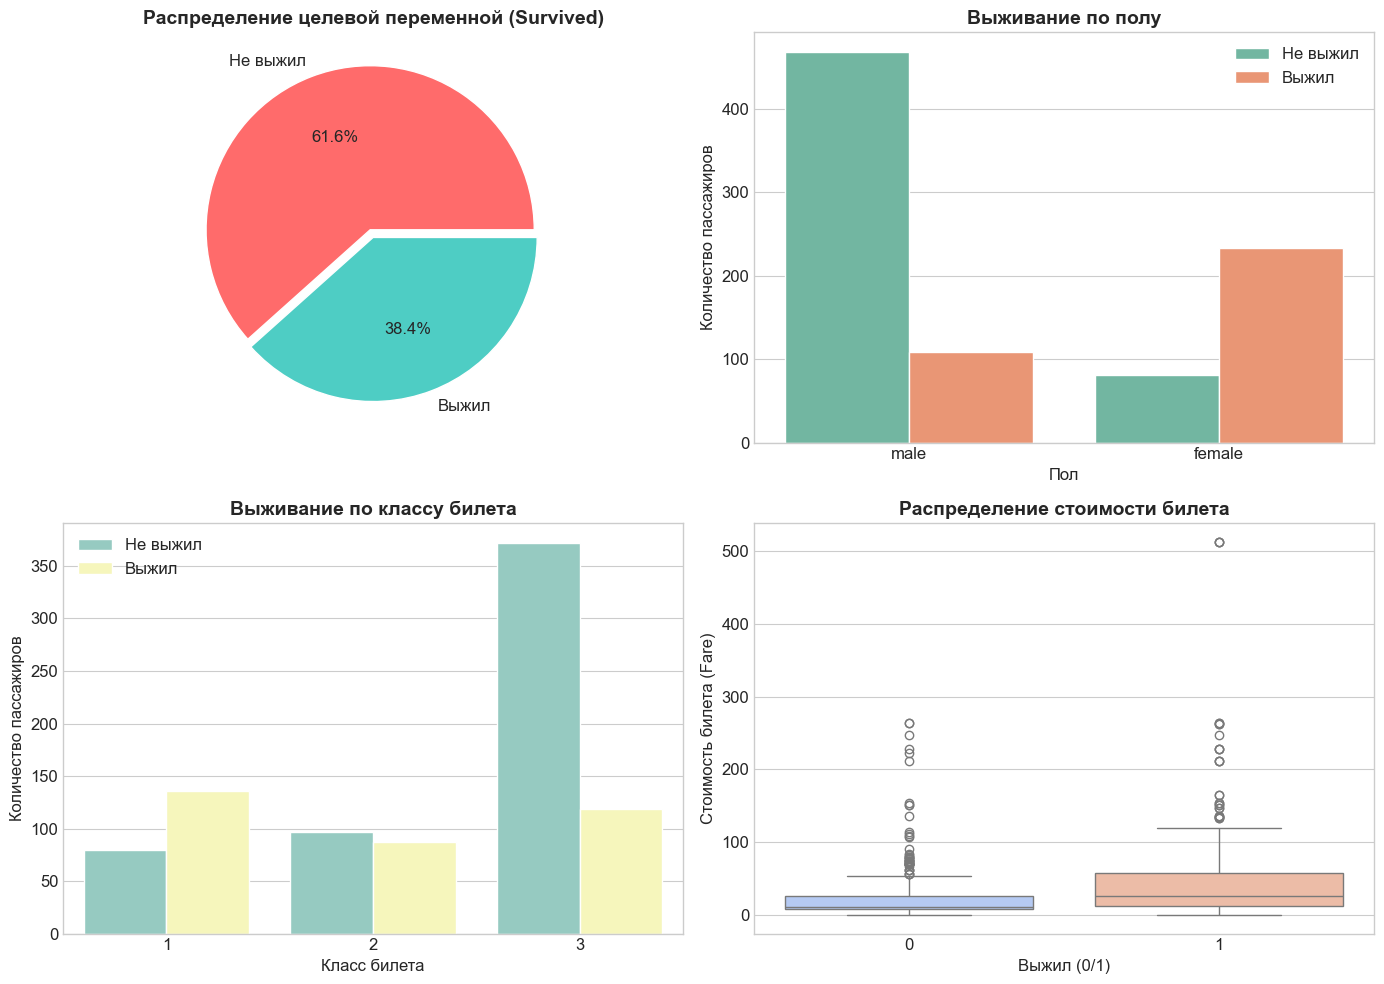

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].pie(
    df['Survived'].value_counts(),
    labels=['Не выжил', 'Выжил'],
    autopct='%1.1f%%',
    colors=['#FF6B6B', '#4ECDC4'],
    explode=(0.05, 0)
)
axes[0, 0].set_title('Распределение целевой переменной (Survived)', fontsize=14, fontweight='bold')

# Выживание по полу (Sex vs Survived)
sns.countplot(data=df, x='Sex', hue='Survived', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Выживание по полу', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Пол')
axes[0, 1].set_ylabel('Количество пассажиров')
axes[0, 1].legend(['Не выжил', 'Выжил'])

# Выживание по классу билета (Pclass vs Survived)
sns.countplot(data=df, x='Pclass', hue='Survived', ax=axes[1, 0], palette='Set3')
axes[1, 0].set_title('Выживание по классу билета', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Класс билета')
axes[1, 0].set_ylabel('Количество пассажиров')
axes[1, 0].legend(['Не выжил', 'Выжил'])

# Распределение стоимости билета по выжившим (Fare ~ Survived)
sns.boxplot(data=df, x='Survived', y='Fare', ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Распределение стоимости билета', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Выжил (0/1)')
axes[1, 1].set_ylabel('Стоимость билета (Fare)')

plt.tight_layout()
plt.savefig('eda_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Предобработка данных

# Копируем датафрейм для работы
df_work = df.copy()

# Заполнение пропусков в Age (медианой по группам Sex + Pclass)
df_work['Age'] = df_work.groupby(['Sex', 'Pclass'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

# Если остались пропуски - заполняем общей медианой
df_work['Age'].fillna(df_work['Age'].median(), inplace=True)
print(f"Пропуски в Age заполнены (осталось: {df_work['Age'].isnull().sum()})")

# Заполнение пропусков в Embarked (модой)
df_work['Embarked'].fillna(df_work['Embarked'].mode()[0], inplace=True)
print(f"Пропуски в Embarked заполнены (осталось: {df_work['Embarked'].isnull().sum()})")

# Заполнение пропусков в Fare (медианой)
df_work['Fare'].fillna(df_work['Fare'].median(), inplace=True)
print(f"Пропуски в Fare заполнены (осталось: {df_work['Fare'].isnull().sum()})")

# Кодирование категориальных признаков
# Sex: male -> 0, female -> 1
df_work['Sex_encoded'] = df_work['Sex'].map({'male': 0, 'female': 1})

# Embarked: one-hot encoding
df_work = pd.get_dummies(df_work, columns=['Embarked'], prefix='Embarked', drop_first=True)

# Class: ordinal encoding (First=3, Second=2, Third=1)
class_mapping = {'First': 3, 'Second': 2, 'Third': 1}
df_work['Pclass_encoded'] = df_work['Pclass'].map(class_mapping)
print("\nЗаполнение пропусков завершено!")


Пропуски в Age заполнены (осталось: 0)
Пропуски в Embarked заполнены (осталось: 2)
Пропуски в Fare заполнены (осталось: 0)

Заполнение пропусков завершено!


In [5]:
# Создание новых признаков (Feature Engineering)
# FamilySize = SibSp + Parch + 1 (сам пассажир)
df_work['family_size'] = df_work['SibSp'] + df_work['Parch'] + 1

# IsAlone: путешествовал ли один
df_work['is_alone'] = (df_work['family_size'] == 1).astype(int)

print(f"Созданы новые признаки: family_size, is_alone")

# 4.6. Отбор признаков для анализа
features_for_analysis = ['Sex_encoded', 'Pclass_encoded', 'Age', 'Fare',
                         'Embarked_Q', 'Embarked_S', 'family_size', 'is_alone']
target = 'survived'

print(f"\nПризнаки для анализа: {features_for_analysis}")
print(f"Целевая переменная: {target}")
print(f"Итоговый размер выборки: {df_work.shape[0]} записей")

Созданы новые признаки: family_size, is_alone

Признаки для анализа: ['Sex_encoded', 'Pclass_encoded', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S', 'family_size', 'is_alone']
Целевая переменная: survived
Итоговый размер выборки: 891 записей


In [6]:
def chi_square_test_independent(col1, col2, alpha=0.05):
    """
    Chi-square test of independence - implementation from scratch.
    Uses scipy.stats.chi2 for distribution functions only.

    H0: variables are independent
    H1: variables are dependent

    Parameters:
    -----------
    col1 : array-like, first categorical variable
    col2 : array-like, second categorical variable
    alpha : float, significance level (default 0.05)

    Returns:
    --------
    dict with statistic, p_value, df, critical_value, regions, reject_h0
    """
    col1 = np.array(col1)
    col2 = np.array(col2)

    # Step 1: Build contingency table
    cat1 = np.unique(col1)
    cat2 = np.unique(col2)

    observed = np.zeros((len(cat1), len(cat2)))
    for i, c1 in enumerate(cat1):
        for j, c2 in enumerate(cat2):
            observed[i, j] = np.sum((col1 == c1) & (col2 == c2))

    # Step 2: Calculate expected frequencies under H0 (independence)
    row_sums = observed.sum(axis=1, keepdims=True)
    col_sums = observed.sum(axis=0, keepdims=True)
    total = observed.sum()
    expected = row_sums @ col_sums / total

    # Step 3: Calculate chi-square statistic
    chi2_stat = np.sum((observed - expected) ** 2 / expected)

    # Step 4: Degrees of freedom
    df = (len(cat1) - 1) * (len(cat2) - 1)

    # Step 5: Critical value from chi-square distribution
    critical_value = chi2.ppf(1 - alpha, df)

    # Step 6: p-value from chi-square distribution
    p_value = 1 - chi2.cdf(chi2_stat, df)

    # Step 7: Decision
    reject_h0 = p_value < alpha

    return {
        'test_name': 'Chi-Square Test of Independence',
        'statistic': chi2_stat,
        'p_value': p_value,
        'df': df,
        'alpha': alpha,
        'critical_value': critical_value,
        'acceptance_region': 'chi2 <= {:.4f}'.format(critical_value),
        'critical_region': 'chi2 > {:.4f}'.format(critical_value),
        'reject_h0': reject_h0,
        'observed': observed,
        'expected': expected
    }

In [7]:
def two_sample_t_test_welch(group1, group2, alpha=0.05, alternative='two-sided'):
    """
    Welch's t-test for independent samples - implementation from scratch.
    Uses scipy.stats.t for distribution functions only.

    H0: mu1 = mu2 (means are equal)
    H1: mu1 != mu2 (means are different)

    Parameters:
    -----------
    group1 : array-like, first sample
    group2 : array-like, second sample
    alpha : float, significance level (default 0.05)
    alternative : str, 'two-sided', 'greater', or 'less'

    Returns:
    --------
    dict with statistic, p_value, df, critical_value, regions, reject_h0
    """
    group1 = np.array(group1)
    group2 = np.array(group2)

    # Remove NaN values
    group1 = group1[~np.isnan(group1)]
    group2 = group2[~np.isnan(group2)]

    # Step 1: Calculate descriptive statistics
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Step 2: Standard error of difference
    se = np.sqrt(var1 / n1 + var2 / n2)

    # Step 3: t-statistic
    t_stat = (mean1 - mean2) / se

    # Step 4: Degrees of freedom (Welch-Satterthwaite)
    df_num = (var1 / n1 + var2 / n2) ** 2
    df_den = (var1 / n1) ** 2 / (n1 - 1) + (var2 / n2) ** 2 / (n2 - 1)
    df = df_num / df_den

    # Step 5: Critical value from t-distribution
    if alternative == 'two-sided':
        critical_value = t.ppf(1 - alpha / 2, df)
    elif alternative == 'greater':
        critical_value = t.ppf(1 - alpha, df)
    else:
        critical_value = t.ppf(alpha, df)

    # Step 6: p-value from t-distribution
    if alternative == 'two-sided':
        p_value = 2 * (1 - t.cdf(abs(t_stat), df))
        crit_region = '|t| > {:.4f}'.format(critical_value)
        acc_region = '|t| <= {:.4f}'.format(critical_value)
    elif alternative == 'greater':
        p_value = 1 - t.cdf(t_stat, df)
        crit_region = 't > {:.4f}'.format(critical_value)
        acc_region = 't <= {:.4f}'.format(critical_value)
    else:
        p_value = t.cdf(t_stat, df)
        crit_region = 't < {:.4f}'.format(critical_value)
        acc_region = 't >= {:.4f}'.format(critical_value)

    # Step 7: Decision
    reject_h0 = p_value < alpha

    return {
        'test_name': "Welch's Two-Sample t-test",
        'statistic': t_stat,
        'p_value': p_value,
        'df': df,
        'alpha': alpha,
        'critical_value': critical_value,
        'acceptance_region': acc_region,
        'critical_region': crit_region,
        'reject_h0': reject_h0,
        'mean1': mean1,
        'mean2': mean2,
        'var1': var1,
        'var2': var2,
        'n1': n1,
        'n2': n2
    }

In [8]:
def print_test_result(result):
    """
    Print test results in formatted way.
    """
    print('=' * 70)
    print('TEST: {}'.format(result['test_name']))
    print('=' * 70)
    print('Statistic: {:.4f}'.format(result['statistic']))
    print('p-value: {:.4e}'.format(result['p_value']))
    print('Degrees of freedom: {:.2f}'.format(result['df']))
    print('Alpha (significance level): {}'.format(result['alpha']))
    print('Critical region: {}'.format(result['critical_region']))
    print('Acceptance region: {}'.format(result['acceptance_region']))
    print('=' * 70)

    if result['reject_h0']:
        print('REJECT H0: effect is STATISTICALLY SIGNIFICANT (p < alpha)')
    else:
        print('FAIL TO REJECT H0: effect is NOT SIGNIFICANT (p >= alpha)')

    print('=' * 70)
    print('\n' * 5)

In [9]:
print('RUNNING STATISTICAL TESTS ON TITANIC DATASET')
print('=' * 70)

# Application 1: Chi-Square (Sex vs Survived)
result1 = chi_square_test_independent(df_work['Sex_encoded'], df_work['Survived'])
print_test_result(result1)

# Application 2: Chi-Square (Pclass vs Survived)
result2 = chi_square_test_independent(df_work['Pclass_encoded'], df_work['Survived'])
print_test_result(result2)

# Application 3: T-test (Fare: Survived=1 vs Survived=0)
fare_survived = df_work[df_work['Survived'] == 1]['Fare'].dropna()
fare_died = df_work[df_work['Survived'] == 0]['Fare'].dropna()
result3 = two_sample_t_test_welch(fare_survived, fare_died)
print_test_result(result3)

# Application 4: T-test (Age: Survived=1 vs Survived=0)
age_survived = df_work[df_work['Survived'] == 1]['Age'].dropna()
age_died = df_work[df_work['Survived'] == 0]['Age'].dropna()
result4 = two_sample_t_test_welch(age_survived, age_died)
print_test_result(result4)

# Summary of significant factors
print()
print('=' * 70)
print('STATISTICALLY SIGNIFICANT FACTORS (alpha=0.05)')
print('=' * 70)
print('\n' * 5)

significant_factors = []
if result1['reject_h0']:
    significant_factors.append('Sex')
    print('Sex (Gender) - SIGNIFICANT factor for survival')
if result2['reject_h0']:
    significant_factors.append('Pclass')
    print('Pclass (Ticket Class) - SIGNIFICANT factor for survival')
if result3['reject_h0']:
    significant_factors.append('Fare')
    print('Fare (Ticket Price) - SIGNIFICANT factor for survival')
if result4['reject_h0']:
    significant_factors.append('Age')
    print('Age - SIGNIFICANT factor for survival')

print()
print('Total significant factors: {}'.format(len(significant_factors)))
print('Factors for ML model: {}'.format(significant_factors))

RUNNING STATISTICAL TESTS ON TITANIC DATASET
TEST: Chi-Square Test of Independence
Statistic: 263.0506
p-value: 0.0000e+00
Degrees of freedom: 1.00
Alpha (significance level): 0.05
Critical region: chi2 > 3.8415
Acceptance region: chi2 <= 3.8415
REJECT H0: effect is STATISTICALLY SIGNIFICANT (p < alpha)






TEST: Chi-Square Test of Independence
Statistic: nan
p-value: nan
Degrees of freedom: 0.00
Alpha (significance level): 0.05
Critical region: chi2 > nan
Acceptance region: chi2 <= nan
FAIL TO REJECT H0: effect is NOT SIGNIFICANT (p >= alpha)






TEST: Welch's Two-Sample t-test
Statistic: 6.8391
p-value: 2.6993e-11
Degrees of freedom: 436.70
Alpha (significance level): 0.05
Critical region: |t| > 1.9654
Acceptance region: |t| <= 1.9654
REJECT H0: effect is STATISTICALLY SIGNIFICANT (p < alpha)






TEST: Welch's Two-Sample t-test
Statistic: -1.7432
p-value: 8.1747e-02
Degrees of freedom: 675.11
Alpha (significance level): 0.05
Critical region: |t| > 1.9635
Acceptance region: |t| 